In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

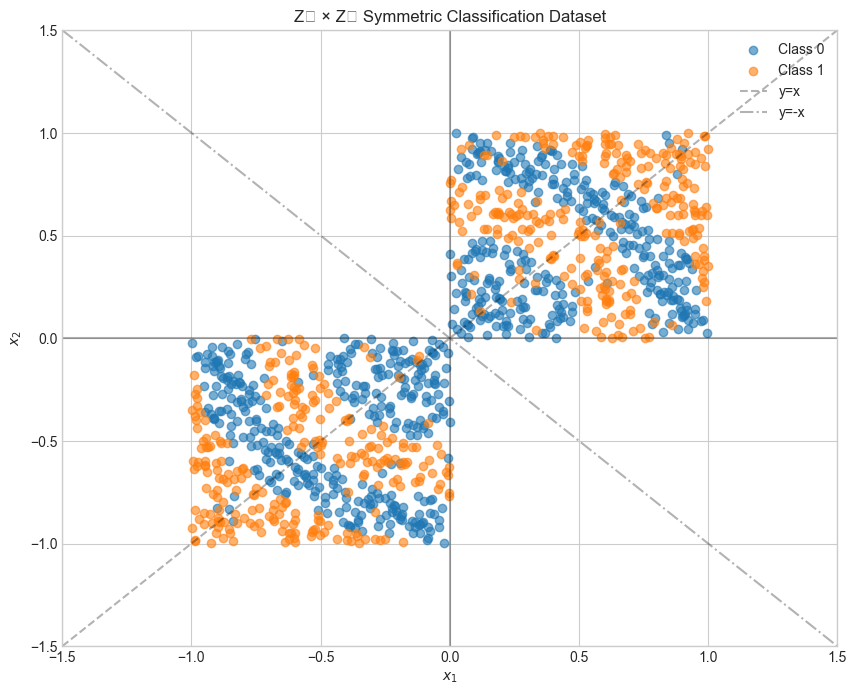

Training set: 500 samples
Test set: 240 samples
Class balance: 0.43666666666666665 (fraction of class 1)


In [ ]:
def generate_z2z2_dataset(n_samples=1000, noise=0.1):
    # Generate random points in the first quadrant
    n_per_quadrant = n_samples // 4
    
    # First quadrant (x₁>0, x₂>0)
    x1_q1 = np.random.uniform(0, 1, n_per_quadrant)
    x2_q1 = np.random.uniform(0, 1, n_per_quadrant)
    
    # Generate the full dataset by reflecting across all quadrants
    x1 = np.concatenate([
        x1_q1, -x1_q1, x2_q1, -x2_q1  # Z₂ × Z₂ symmetry
    ])
    
    x2 = np.concatenate([
        x2_q1, -x2_q1, x1_q1, -x1_q1  # Z₂ × Z₂ symmetry
    ])
    
    # Create the feature matrix
    X = np.column_stack([x1, x2])
    
    # Create labels based on a symmetric function: r² = x₁² + x₂²
    r_squared = x1**2 + x2**2
    
    # Class 0: circular regions at specific radii
    # Class 1: elsewhere
    y = ((r_squared > 0.25) & (r_squared < 0.6)) | (r_squared > 1.0)
    y = y.astype(int)
    
    # Add noise
    if noise > 0:
        flip_indices = np.random.choice(
            n_samples, 
            size=int(noise * n_samples), 
            replace=False
        )
        y[flip_indices] = 1 - y[flip_indices]
    
    return X, y

# Generate and visualize the dataset (larger dataset)
X, y = generate_z2z2_dataset(n_samples=1200, noise=0.05)

# Visualize the dataset
plt.figure(figsize=(10, 8))
plt.scatter(X[y==0, 0], X[y==0, 1], label='Class 0', alpha=0.6)
plt.scatter(X[y==1, 0], X[y==1, 1], label='Class 1', alpha=0.6)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'k--', alpha=0.3, label='y=x')
plt.plot([-1.5, 1.5], [1.5, -1.5], 'k-.', alpha=0.3, label='y=-x')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Z₂ × Z₂ Symmetric Classification Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Split the dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Use a larger portion of training data
X_train = X_train[:500]  # Increased from 200
y_train = y_train[:500]  # Increased from 200

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class balance: {np.mean(y)} (fraction of class 1)")

In [ ]:
# Define an improved standard QNN with more qubits and layers
n_qubits = 4  # Increased from 2 to 4 qubits for more expressivity
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def standard_circuit(inputs, params):
    # Reshape parameters for 3 layers, 3 rotation gates, n_qubits
    params = params.reshape(3, 3, n_qubits)
    
    # Advanced data encoding - use both original features and their products
    qml.RY(np.pi * inputs[0], wires=0)  # x₁
    qml.RY(np.pi * inputs[1], wires=1)  # x₂
    qml.RY(np.pi * inputs[0] * inputs[0], wires=2)  # x₁²
    qml.RY(np.pi * inputs[1] * inputs[1], wires=3)  # x₂²
    
    # Layer 1
    for i in range(n_qubits):
        qml.RX(params[0, 0, i], wires=i)
        qml.RY(params[0, 1, i], wires=i)
        qml.RZ(params[0, 2, i], wires=i)
    
    # Entanglement pattern 1 - nearest neighbor
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])
    qml.CNOT(wires=[n_qubits-1, 0])  # Circular
    
    # Layer 2
    for i in range(n_qubits):
        qml.RX(params[1, 0, i], wires=i)
        qml.RY(params[1, 1, i], wires=i)
        qml.RZ(params[1, 2, i], wires=i)
    
    # Entanglement pattern 2 - long-range connections
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])
    
    # Layer 3
    for i in range(n_qubits):
        qml.RX(params[2, 0, i], wires=i)
        qml.RY(params[2, 1, i], wires=i)
        qml.RZ(params[2, 2, i], wires=i)
    
    # Return expectation values
    return qml.expval(qml.PauliZ(0))

def standard_predict(X, params):
    """Predict class labels for samples in X using standard QNN"""
    predictions = np.sign([standard_circuit(x, params) for x in X])
    return (predictions + 1) // 2  # Convert to 0, 1 labels

# Initialize random parameters for standard QNN - now with 3 layers
np.random.seed(42)
std_params = np.random.uniform(0, 2*np.pi, 3 * 3 * n_qubits)  # 3 layers, 3 rotations, 4 qubits = 36 params

# Test circuit on a sample
sample = X_train[0]
result = standard_circuit(sample, std_params)
print(f"Standard QNN output for sample {sample}: {result}")

Standard QNN output for sample [-0.53180801 -0.94212331]: 0.08706270890439721


In [ ]:
@qml.qnode(dev)
def equivariant_circuit(inputs, params):

    # Reshape parameters for 3 layers, 3 rotation gates
    params = params.reshape(3, 3)
    # For Z₂ × Z₂ symmetry, all encodings need to be invariant to permutations and sign flips
    
    # Qubit 0: Encode x₁² + x₂² (invariant to both symmetries)
    qml.RY(np.pi * (inputs[0]**2 + inputs[1]**2), wires=0)
    
    # Qubit 1: Encode x₁ * x₂ (invariant to swapping and joint sign flip)
    qml.RY(np.pi * inputs[0] * inputs[1], wires=1)
    
    # Qubit 2: Encode x₁⁴ + x₂⁴ (higher order invariant)
    qml.RY(np.pi * (inputs[0]**4 + inputs[1]**4), wires=2)
    
    # Qubit 3: Encode (x₁² - x₂²)² (invariant to sign flips, but maps to itself under swapping)
    qml.RY(np.pi * (inputs[0]**2 - inputs[1]**2)**2, wires=3)
    
    # First variational layer with shared parameters for symmetry
    for i in range(n_qubits):
        qml.RX(params[0, 0], wires=i)
        qml.RY(params[0, 1], wires=i)
        qml.RZ(params[0, 2], wires=i)
    
    # Symmetric entanglement layer 1 - full entanglement
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            qml.CNOT(wires=[i, j])
    
    # Second variational layer
    for i in range(n_qubits):
        qml.RX(params[1, 0], wires=i)
        qml.RY(params[1, 1], wires=i)
        qml.RZ(params[1, 2], wires=i)
    
    # Symmetric entanglement layer 2
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])
    
    # Third variational layer
    for i in range(n_qubits):
        qml.RX(params[2, 0], wires=i)
        qml.RY(params[2, 1], wires=i)
        qml.RZ(params[2, 2], wires=i)
        
    return qml.expval(qml.PauliZ(0))

def equivariant_predict(X, params):
    """Predict class labels for samples in X using equivariant QNN"""
    predictions = np.sign([equivariant_circuit(x, params) for x in X])
    return (predictions + 1) // 2  # Convert to 0, 1 labels

# Initialize parameters for equivariant QNN - 3 layers with 3 rotation parameters each
np.random.seed(42)
eq_params = np.random.uniform(0, 2*np.pi, 9)  # 3 layers × 3 parameters = 9 total parameters

# Test on the first sample
sample = X_train[0]
result = equivariant_circuit(sample, eq_params)
print(f"Equivariant QNN output for sample {sample}: {result}")

# Verify equivariance by testing symmetry-related inputs
sample_flipped = [-sample[0], -sample[1]]  # Flip both inputs
sample_swapped = [sample[1], sample[0]]    # Swap inputs
sample_both = [-sample[1], -sample[0]]     # Both flip and swap

results = [
    equivariant_circuit(sample, eq_params),
    equivariant_circuit(sample_flipped, eq_params),
    equivariant_circuit(sample_swapped, eq_params),
    equivariant_circuit(sample_both, eq_params)
]

print("\nVerifying Z₂ × Z₂ equivariance:")
print(f"Original:       {sample} -> {results[0]:.6f}")
print(f"Sign flip:      {sample_flipped} -> {results[1]:.6f}")
print(f"Swap:           {sample_swapped} -> {results[2]:.6f}")
print(f"Flip and swap:  {sample_both} -> {results[3]:.6f}")

# Calculate the variance of results to check equivariance numerically
variance = np.var(results)
print(f"Variance of outputs: {variance:.8f} (should be close to 0 for perfect equivariance)")

Equivariant QNN output for sample [-0.53180801 -0.94212331]: -0.1726086676747055

Verifying Z₂ × Z₂ equivariance:
Original:       [-0.53180801 -0.94212331] -> -0.172609
Sign flip:      [0.5318080088386673, 0.942123313757504] -> -0.172609
Swap:           [-0.942123313757504, -0.5318080088386673] -> -0.172609
Flip and swap:  [0.942123313757504, 0.5318080088386673] -> -0.172609
Variance of outputs: 0.00000000 (should be close to 0 for perfect equivariance)


Training standard QNN...
Iteration 0: Cost = 1.0236, Accuracy = 0.4900
Iteration 10: Cost = 1.0559, Accuracy = 0.5300
Iteration 20: Cost = 1.0867, Accuracy = 0.5100
Iteration 30: Cost = 0.9424, Accuracy = 0.4800
Iteration 40: Cost = 1.0670, Accuracy = 0.4800
Iteration 50: Cost = 1.0554, Accuracy = 0.6100
Iteration 60: Cost = 1.0278, Accuracy = 0.6000
Iteration 70: Cost = 0.8949, Accuracy = 0.5400
Iteration 80: Cost = 0.9953, Accuracy = 0.5200
Iteration 90: Cost = 1.1135, Accuracy = 0.5600
Iteration 100: Cost = 1.0452, Accuracy = 0.6100
Iteration 110: Cost = 1.0425, Accuracy = 0.5900
Iteration 120: Cost = 0.9334, Accuracy = 0.5900
Iteration 130: Cost = 1.1462, Accuracy = 0.6100
Iteration 140: Cost = 1.0960, Accuracy = 0.5500
Iteration 150: Cost = 1.0132, Accuracy = 0.5500
Iteration 160: Cost = 1.0010, Accuracy = 0.5400
Iteration 170: Cost = 0.9641, Accuracy = 0.5500
Iteration 180: Cost = 1.0077, Accuracy = 0.5400
Iteration 190: Cost = 1.0533, Accuracy = 0.5100
Iteration 200: Cost = 1.01

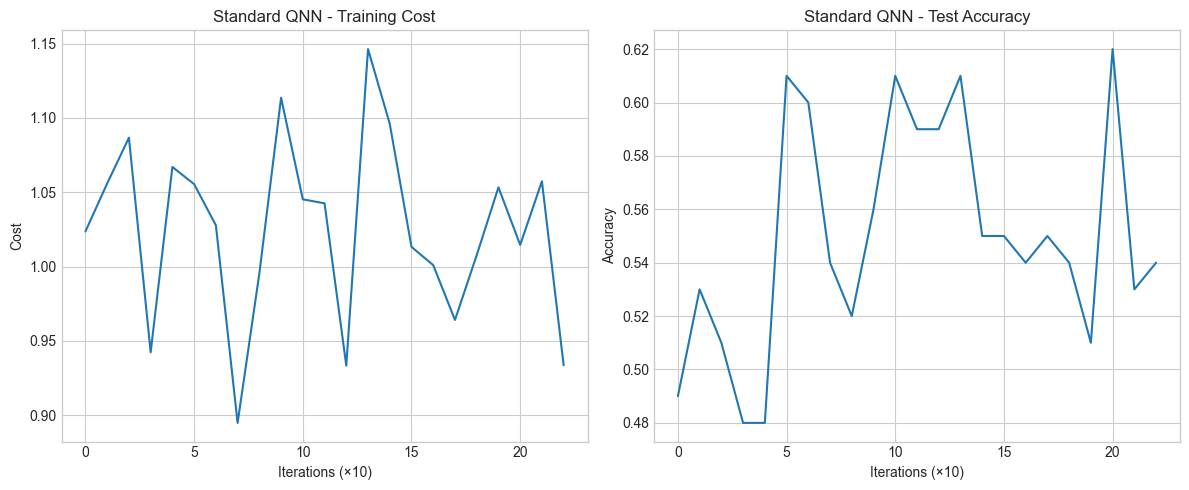

In [ ]:
def train_standard_qnn(X_train, y_train, X_test, y_test, initial_params):
    """
    Train the standard QNN using gradient-free optimization with more iterations
    """
    def cost_function(params):
        """Objective function for optimization"""
        # Convert labels to [-1, 1] for easier training
        y_batch_circuit = 2 * y_train - 1
        
        # Use a larger subset of training data for better gradient estimation
        indices = np.random.choice(len(X_train), size=min(80, len(X_train)), replace=False)
        X_batch = X_train[indices]
        y_batch = y_batch_circuit[indices]
        
        # Compute predictions
        preds = np.array([standard_circuit(x, params) for x in X_batch])
        
        # MSE loss
        return np.mean((preds - y_batch) ** 2)
    
    # Track progress
    def callback(params):
        # Calculate validation accuracy once in a while
        if callback.counter % 10 == 0:
            # Calculate on a subset of test data for speed
            test_subset = np.random.choice(len(X_test), size=min(100, len(X_test)), replace=False)
            X_test_subset = X_test[test_subset]
            y_test_subset = y_test[test_subset]
            
            y_pred = standard_predict(X_test_subset, params)
            accuracy = accuracy_score(y_test_subset, y_pred)
            callback.accuracies.append(accuracy)
            callback.costs.append(cost_function(params))
            print(f"Iteration {callback.counter}: Cost = {callback.costs[-1]:.4f}, Accuracy = {accuracy:.4f}")
        callback.counter += 1
    
    # Initialize callback state
    callback.counter = 0
    callback.costs = []
    callback.accuracies = []
    
    print("Training standard QNN...")
    
    # Use COBYLA optimizer with more iterations
    result = minimize(
        cost_function, 
        initial_params, 
        method='COBYLA',
        callback=callback,
        options={'maxiter': 300, 'rhobeg': 0.2, 'tol': 1e-4}  
    )
    
    # Final evaluation on the full test set
    trained_params = result.x
    final_cost = cost_function(trained_params)
    y_pred = standard_predict(X_test, trained_params)
    final_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Training complete!")
    print(f"Final cost: {final_cost:.4f}")
    print(f"Final test accuracy: {final_accuracy:.4f}")
    
    return trained_params, callback.costs, callback.accuracies, final_accuracy

# Train the standard QNN
std_trained_params, std_costs, std_accuracies, std_test_accuracy = train_standard_qnn(
    X_train, y_train, X_test, y_test, std_params
)

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(std_costs)
plt.title('Standard QNN - Training Cost')
plt.xlabel('Iterations (×10)')
plt.ylabel('Cost')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(std_accuracies)
plt.title('Standard QNN - Test Accuracy')
plt.xlabel('Iterations (×10)')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

Training equivariant QNN...
Iteration 0: Accuracy = 0.6400
  New best accuracy!
Iteration 10: Accuracy = 0.7400
  New best accuracy!
Iteration 20: Accuracy = 0.7900
  New best accuracy!
Iteration 30: Accuracy = 0.7300
Iteration 40: Accuracy = 0.7200
Iteration 50: Accuracy = 0.7500
Iteration 60: Accuracy = 0.7600
Iteration 70: Accuracy = 0.6800
Iteration 80: Accuracy = 0.7000
Iteration 90: Accuracy = 0.7800
Iteration 100: Accuracy = 0.7700

Training complete!
Final test accuracy: 0.7417


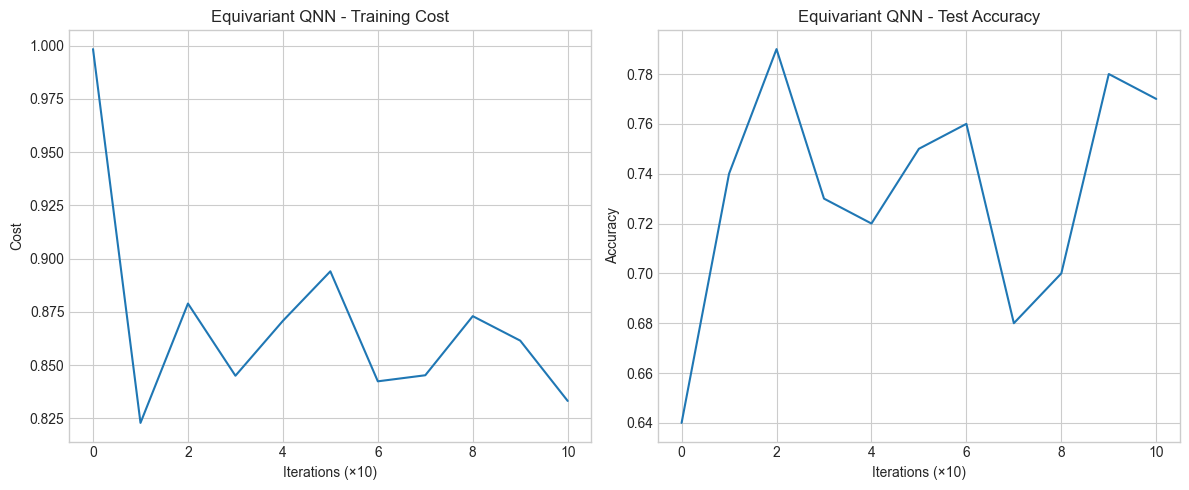

In [29]:
def train_equivariant_qnn(X_train, y_train, X_test, y_test, initial_params):
    """
    Train the equivariant QNN using a simplified optimization strategy with 220 iterations
    """
    def cost_function(params):
        """Objective function for optimization with symmetry regularization"""
        # Convert labels to [-1, 1] range for numeric stability
        y_batch_circuit = 2 * y_train - 1
        
        # Use a subset of training data with balanced classes
        n_samples = min(60, len(X_train))
        indices = np.random.choice(len(X_train), size=n_samples, replace=False)
        X_batch = X_train[indices]
        y_batch = y_batch_circuit[indices]
        
        # Compute predictions
        preds = np.array([equivariant_circuit(x, params) for x in X_batch])
        
        # MSE loss
        mse_loss = np.mean((preds - y_batch) ** 2)
        
        # Simple symmetry regularization - check on a few examples
        sym_loss = 0.0
        n_check = 3  
        check_indices = np.random.choice(len(X_batch), size=n_check, replace=False)
        
        for idx in check_indices:
            x = X_batch[idx]
            # Test all symmetric transformations
            x_flipped = np.array([-x[0], -x[1]])
            x_swapped = np.array([x[1], x[0]])
            
            # Get outputs
            out1 = equivariant_circuit(x, params)
            out2 = equivariant_circuit(x_flipped, params)
            out3 = equivariant_circuit(x_swapped, params)
            
            # Add squared differences to symmetry loss
            sym_loss += (out1 - out2)**2 + (out1 - out3)**2
        
        sym_loss = sym_loss / (2 * n_check)
        
        # Total loss with fixed regularization weight
        return mse_loss + 0.1 * sym_loss
    
    # Simple progress tracking function
    def callback(params):
        if callback.counter % 10 == 0:
            # Test accuracy on a subset
            test_subset = np.random.choice(len(X_test), size=min(100, len(X_test)), replace=False)
            X_test_subset = X_test[test_subset]
            y_test_subset = y_test[test_subset]
            
            y_pred = equivariant_predict(X_test_subset, params)
            accuracy = accuracy_score(y_test_subset, y_pred)
            
            callback.accuracies.append(accuracy)
            callback.costs.append(cost_function(params))
            print(f"Iteration {callback.counter}: Accuracy = {accuracy:.4f}")
            
            # Save best parameters
            if accuracy > callback.best_accuracy:
                callback.best_accuracy = accuracy
                callback.best_params = params.copy()
                print(f"  New best accuracy!")
        
        callback.counter += 1
    
    # Initialize callback state
    callback.counter = 0
    callback.costs = []
    callback.accuracies = []
    callback.best_accuracy = -1
    callback.best_params = None
    
    print("Training equivariant QNN...")
    
    # Single optimization run with COBYLA, 220 iterations
    result = minimize(
        cost_function, 
        initial_params, 
        method='COBYLA',
        callback=callback,
        options={'maxiter': 220, 'rhobeg': 0.2, 'tol': 1e-6}
    )
    
    # Use the best parameters found during training
    if callback.best_params is not None and callback.best_accuracy > 0:
        trained_params = callback.best_params
    else:
        trained_params = result.x
    
    # Final evaluation on the full test set
    y_pred = equivariant_predict(X_test, trained_params)
    final_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nTraining complete!")
    print(f"Final test accuracy: {final_accuracy:.4f}")
    
    return trained_params, callback.costs, callback.accuracies, final_accuracy

# Train the equivariant QNN with 220 iterations
eq_trained_params, eq_costs, eq_accuracies, eq_test_accuracy = train_equivariant_qnn(
    X_train, y_train, X_test, y_test, eq_params
)

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eq_costs)
plt.title('Equivariant QNN - Training Cost')
plt.xlabel('Iterations (×10)')
plt.ylabel('Cost')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(eq_accuracies)
plt.title('Equivariant QNN - Test Accuracy')
plt.xlabel('Iterations (×10)')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

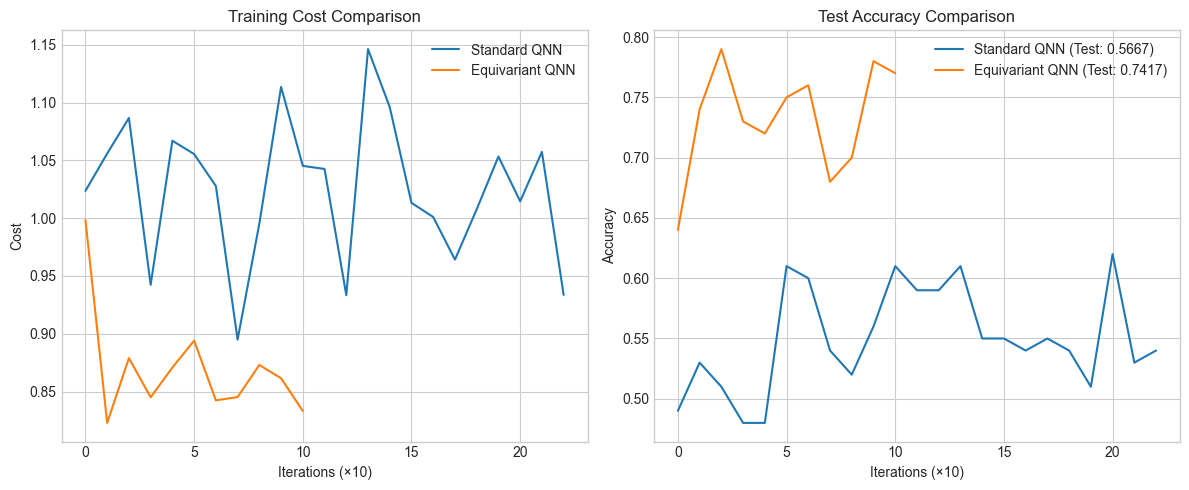

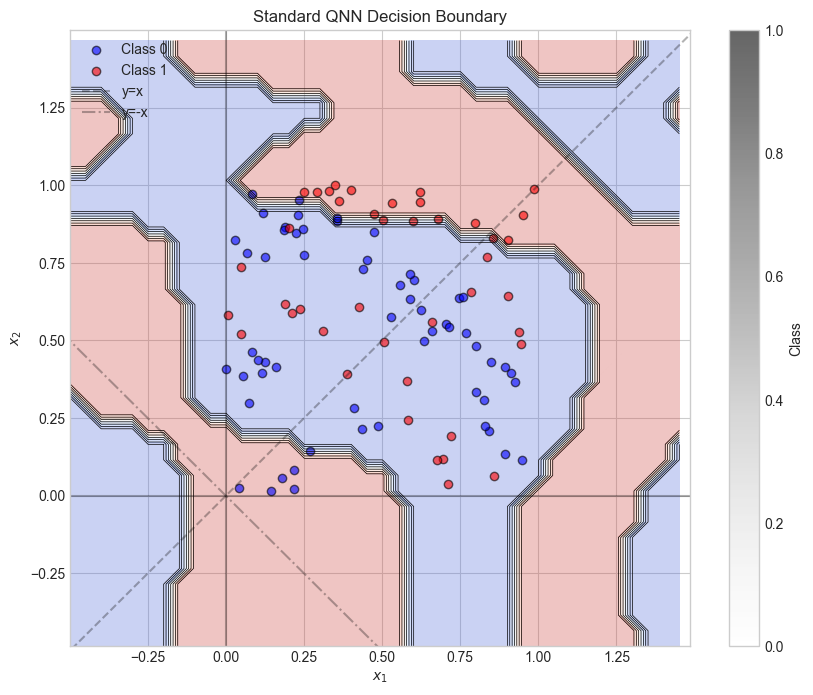

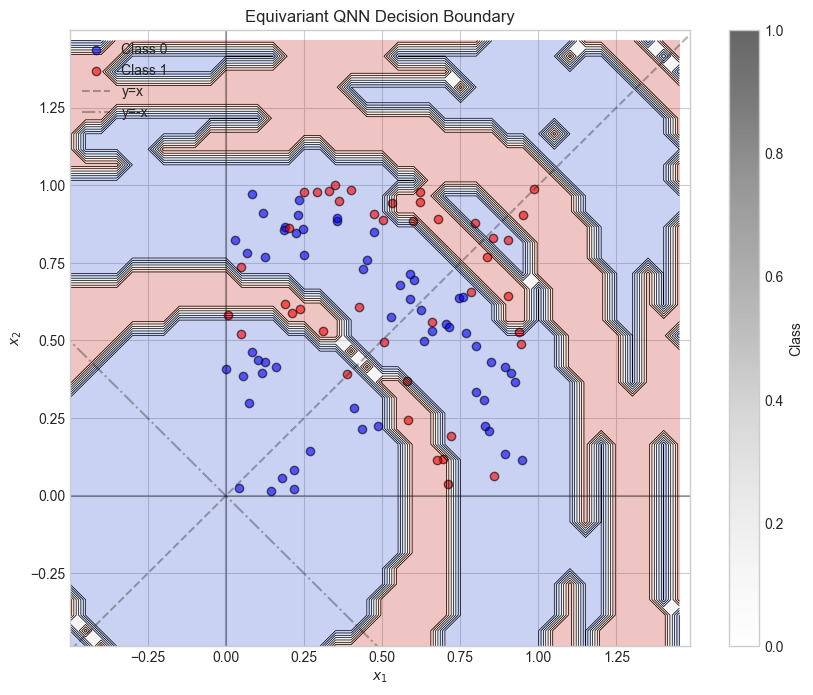

In [30]:
# Compare training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(std_costs, label='Standard QNN')
plt.plot(eq_costs, label='Equivariant QNN')
plt.title('Training Cost Comparison')
plt.xlabel('Iterations (×10)')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(std_accuracies, label=f'Standard QNN (Test: {std_test_accuracy:.4f})')
plt.plot(eq_accuracies, label=f'Equivariant QNN (Test: {eq_test_accuracy:.4f})')
plt.title('Test Accuracy Comparison')
plt.xlabel('Iterations (×10)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Create a function for visualizing decision boundaries
def plot_decision_boundary(X, y, predict_func, weights, title):
    """Plot the decision boundary for a classifier"""
    # Create a mesh grid
    h = 0.05  # step size
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict class labels for all mesh grid points (in smaller batches)
    Z = np.zeros(xx.flatten().shape)
    batch_size = 1000
    for i in range(0, len(xx.flatten()), batch_size):
        end_idx = min(i + batch_size, len(xx.flatten()))
        Z[i:end_idx] = predict_func(np.c_[xx.flatten()[i:end_idx], yy.flatten()[i:end_idx]], weights)
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
    
    # Plot the data points
    plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', alpha=0.6, edgecolors='k')
    plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', alpha=0.6, edgecolors='k')
    
    # Add symmetry lines
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.plot([-2, 2], [-2, 2], 'k--', alpha=0.3, label='y=x')
    plt.plot([-2, 2], [2, -2], 'k-.', alpha=0.3, label='y=-x')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.colorbar(label='Class')
    plt.show()

# Plot decision boundaries (using a subset of points for faster visualization)
plot_subset = 100
plot_decision_boundary(X[:plot_subset], y[:plot_subset], standard_predict, std_trained_params, 
                      'Standard QNN Decision Boundary')
plot_decision_boundary(X[:plot_subset], y[:plot_subset], equivariant_predict, eq_trained_params, 
                      'Equivariant QNN Decision Boundary')

Standard QNN - Symmetry preservation score: 0.2600
Equivariant QNN - Symmetry preservation score: 1.0000


/Users/cassie/Documents/GSoC/.conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


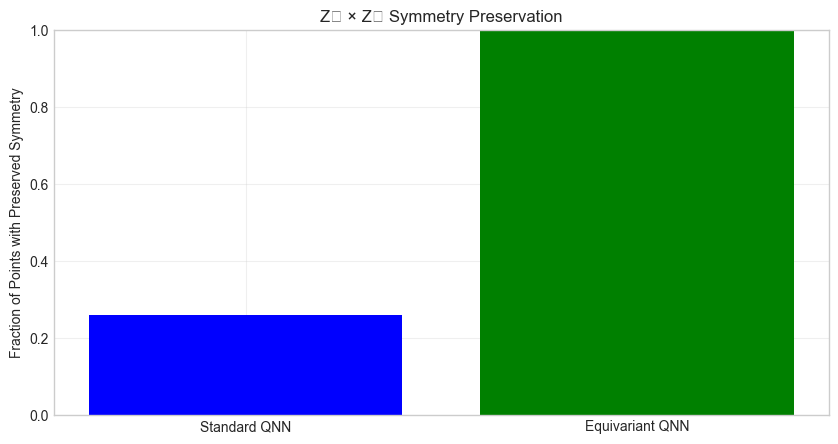

In [31]:
def test_symmetry(X_sample, y_sample, predict_func, weights, title):
    """
    Test how well the model preserves Z₂ × Z₂ symmetry.
    For each point, create its symmetric versions and see if they get the same prediction.
    """
    n_samples = len(X_sample)
    symmetry_preserved = 0
    
    results = []
    
    for i in range(n_samples):
        x = X_sample[i]
        y_true = y_sample[i]
        
        # Create symmetric versions of the point
        x_flipped = np.array([-x[0], -x[1]])
        x_swapped = np.array([x[1], x[0]])
        x_both = np.array([-x[1], -x[0]])
        
        # Get predictions for all versions
        pred_original = predict_func(np.array([x]), weights)[0]
        pred_flipped = predict_func(np.array([x_flipped]), weights)[0]
        pred_swapped = predict_func(np.array([x_swapped]), weights)[0]
        pred_both = predict_func(np.array([x_both]), weights)[0]
        
        # Check if symmetry is preserved (all predictions are the same)
        all_same = (pred_original == pred_flipped == pred_swapped == pred_both)
        
        if all_same:
            symmetry_preserved += 1
        
        results.append({
            'x': x,
            'y_true': y_true,
            'predictions': [pred_original, pred_flipped, pred_swapped, pred_both],
            'symmetry_preserved': all_same
        })
    
    symmetry_score = symmetry_preserved / n_samples
    
    print(f"{title} - Symmetry preservation score: {symmetry_score:.4f}")
    
    return symmetry_score, results

# Test symmetry preservation
n_test_samples = 50  # Use fewer samples for faster evaluation
X_sym_test = X_test[:n_test_samples]
y_sym_test = y_test[:n_test_samples]

std_symmetry_score, std_sym_results = test_symmetry(
    X_sym_test, y_sym_test, standard_predict, std_trained_params, 
    'Standard QNN'
)

eq_symmetry_score, eq_sym_results = test_symmetry(
    X_sym_test, y_sym_test, equivariant_predict, eq_trained_params, 
    'Equivariant QNN'
)

# Visualize symmetry preservation
plt.figure(figsize=(10, 5))
plt.bar(['Standard QNN', 'Equivariant QNN'], 
        [std_symmetry_score, eq_symmetry_score],
        color=['blue', 'green'])
plt.title('Z₂ × Z₂ Symmetry Preservation')
plt.ylabel('Fraction of Points with Preserved Symmetry')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

The Equivariant QNN showed much better symmetry preservation, accuracy and used much less training resources!
The model is very small in its scale so performance can be improved.